<a href="https://colab.research.google.com/github/Gvascons/Parking_Spot_Detection/blob/main/RNN_Parking_Lot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import torch
import datetime
import numpy as np
import pandas as pd
from torch import nn
import tensorflow as tf
from torch import optim
import torch
import torch.nn as nn
from torch.autograd import Variable 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def scaler(X, y):
  mm = MinMaxScaler()
  ss = StandardScaler()

  X_ss = ss.fit_transform(X)
  y_mm = mm.fit_transform(y) 
  return X_ss, y_mm, mm

In [ ]:
def train_test_split(X_ss, y_mm, pc = 0.8):
  X_train = X_ss[:int(pc*len(X_ss)), :]
  X_test = X_ss[int(pc*len(X_ss)):, :]

  y_train = y_mm[:int(pc*len(X_ss)), :]
  y_test = y_mm[int(pc*len(X_ss)):, :] 

  X_train_tensors = Variable(torch.Tensor(X_train))
  y_train_tensors = Variable(torch.Tensor(y_train))

  X_test_tensors = Variable(torch.Tensor(X_test))
  y_test_tensors = Variable(torch.Tensor(y_test))

  X_train_tensors = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

  X_test_tensors = torch.reshape(X_test_tensors,   (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

  return X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors

In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 6 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()#.to(device)
        return hidden

In [ ]:
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=1000, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%100 == 0:
          print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
          print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, mm):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    h = model.init_hidden(test_x.shape[0])
    out, h = model(test_x.to(device).float(), h)

    outputs.append(mm.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(mm.inverse_transform(test_y.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
dr_path = '/content/gdrive/MyDrive/ParkingLotDL/'

## CNRPark

In [ ]:
CNRParkOc = pd.read_csv(dr_path + 'CNRPark/occupancyCNRPark.csv')

In [ ]:
CNRParkOc['weather'] = CNRParkOc['weather'].astype('category').cat.codes

In [ ]:
CNRParkOc[['year', 'month', 'rest']] = CNRParkOc['Unnamed: 0'].str.split('-', expand=True)

In [ ]:
CNRParkOc[['day', 'rest']] = CNRParkOc['rest'].str.split('_', expand=True)

In [ ]:
CNRParkOc[['hour', 'minutes']] = CNRParkOc['rest'].str.split('.', expand=True)

In [ ]:
def convert(x):
  return datetime.datetime.strptime(x['Unnamed: 0'], "%Y-%m-%d_%H.%M").weekday()

In [ ]:
CNRParkOc['weekday'] = CNRParkOc.apply(convert, axis=1)

In [ ]:
CNRParkOc[['occupancy', 'weather', 'year', 'month', 'day', 'hour', 'minutes', 'weekday']]

,occupancy,weather,year,month,day,hour,minutes,weekday
0,6,2,2015,07,03,08,05,4
1,7,2,2015,07,03,08,10,4
2,8,2,2015,07,03,08,15,4
3,8,2,2015,07,03,08,20,4
4,9,2,2015,07,03,08,25,4
...,...,...,...,...,...,...,...,...
3411,4,1,2016,02,12,17,35,4
3412,10,1,2016,02,12,17,36,4
3413,20,1,2016,02,12,17,41,4
3414,14,1,2016,02,12,17,42,4


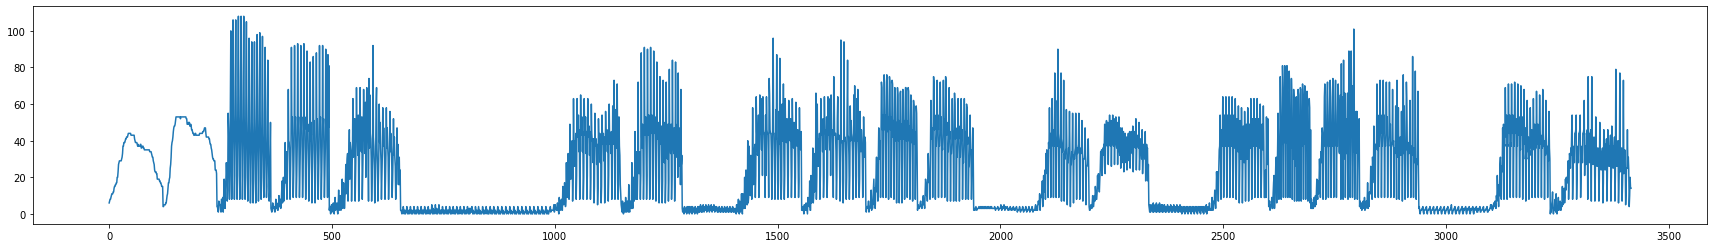

In [ ]:
plt.figure(figsize=(30, 4))
plt.plot(CNRParkOc['occupancy'])

In [ ]:
X = CNRParkOc[['weather', 'year', 'month', 'day', 'hour', 'minutes', 'weekday']]
y = CNRParkOc[['occupancy']]

In [ ]:
y

,occupancy
0,6
1,7
2,8
3,8
4,9
...,...
3411,4
3412,10
3413,20
3414,14


In [ ]:
X

,weather,year,month,day,hour,minutes,weekday
0,2,2015,07,03,08,05,4
1,2,2015,07,03,08,10,4
2,2,2015,07,03,08,15,4
3,2,2015,07,03,08,20,4
4,2,2015,07,03,08,25,4
...,...,...,...,...,...,...,...
3411,1,2016,02,12,17,35,4
3412,1,2016,02,12,17,36,4
3413,1,2016,02,12,17,41,4
3414,1,2016,02,12,17,42,4


In [ ]:
X_ss, y_mm, mm = scaler(X, y)
X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors = train_test_split(X_ss, y_mm)

In [ ]:
batch_size = 16
train_data = TensorDataset(X_train_tensors_final, y_train_tensors)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
print("Training Shape", train_loader)

Training Shape <torch.utils.data.dataloader.DataLoader object at 0x7faf0377ac90>


In [ ]:
gru_model = train(train_loader, learning_rate, model_type="GRU")
Lstm_model = train(train_loader, learning_rate, model_type="LSTM")

Starting Training of GRU model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 100/1000 Done, Total Loss: 0.01720568806905409
Total Time Elapsed: 0.44162900000000604 seconds
Epoch 200/1000 Done, Total Loss: 0.017016428080387412
Total Time Elapsed: 0.45042899999999975 seconds
Epoch 300/1000 Done, Total Loss: 0.01692744254901567
Total Time Elapsed: 0.4480739999999912 seconds
Epoch 400/1000 Done, Total Loss: 0.01683033605119871
Total Time Elapsed: 0.44617600000000834 seconds
Epoch 500/1000 Done, Total Loss: 0.016622766627080957
Total Time Elapsed: 0.4276230000000112 seconds
Epoch 600/1000 Done, Total Loss: 0.016214340766344
Total Time Elapsed: 0.43460599999997385 seconds
Epoch 700/1000 Done, Total Loss: 0.015381523914059952
Total Time Elapsed: 0.44275699999997187 seconds
Epoch 800/1000 Done, Total Loss: 0.01529765839839135
Total Time Elapsed: 0.43607400000001917 seconds
Epoch 900/1000 Done, Total Loss: 0.01434293802252368
Total Time Elapsed: 0.428984000000014 seconds
Epoch 1000/1000 Done, Total Loss: 0.014302102164776228
Total Time Elapsed: 0.4227840000000356 

In [ ]:
PATH = dr_path + 'models/GRUPUCPR.pth'
torch.save(gru_model.state_dict(), PATH)
PATH = dr_path + 'models/LSTMPUCPR.pth'
torch.save(Lstm_model.state_dict(), PATH)

In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, X_test_tensors_final, y_test_tensors, mm)

Evaluation Time: 0.005403000000001157
sMAPE: 14.543408155441284%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(Lstm_model, X_test_tensors_final, y_test_tensors, mm)

Evaluation Time: 0.007699999999999818
sMAPE: 3.288859501481056%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


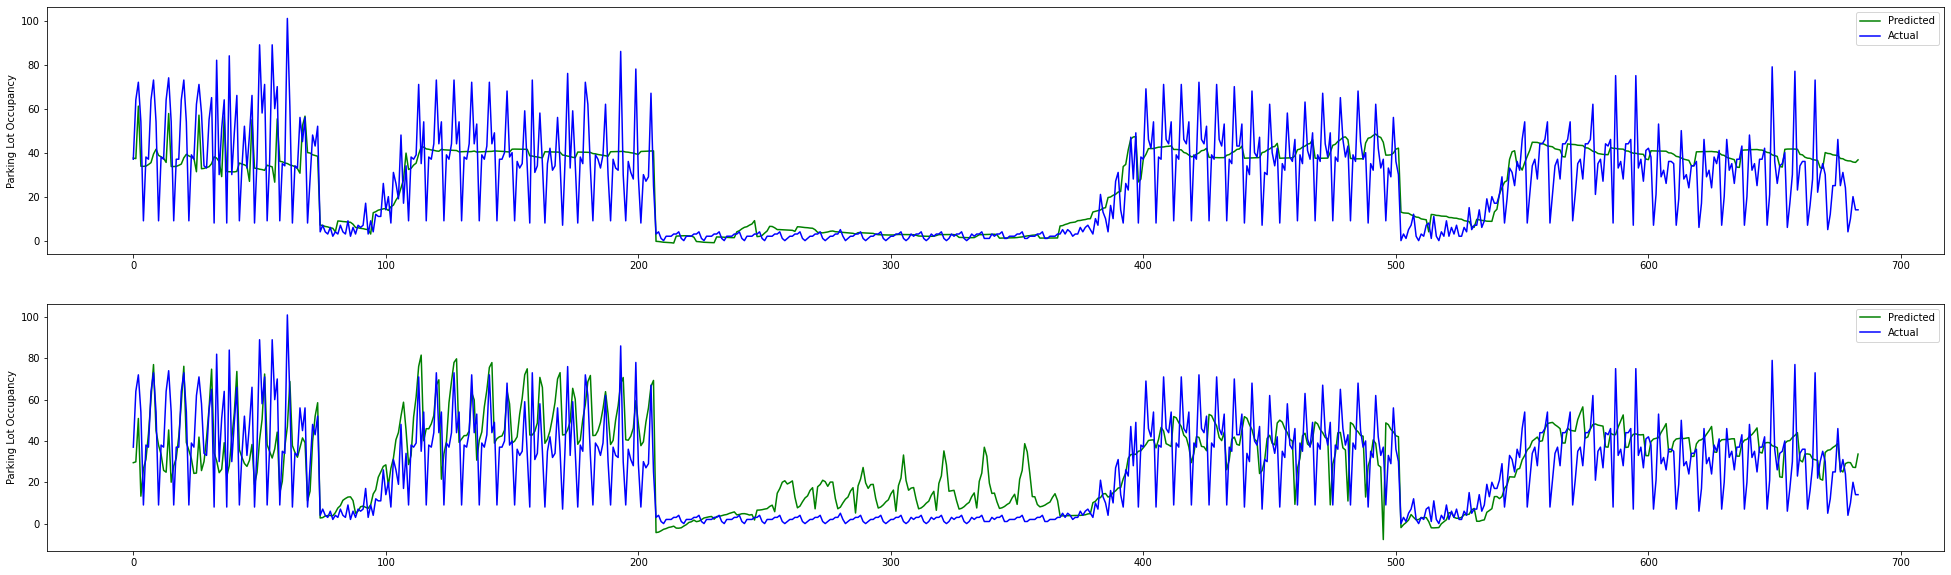

In [ ]:
plt.figure(figsize=(34,10))
plt.subplot(2,1, 1)
plt.plot(gru_outputs[0], color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Parking Lot Occupancy')
plt.legend()

plt.subplot(2,1, 2)
plt.plot(lstm_outputs[0], color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Parking Lot Occupancy')
plt.legend()
plt.show()

## PKLot

In [ ]:
PKLotOc = pd.read_csv(dr_path + 'PKLot/occupancyPKLot.csv')

In [ ]:
PKLotOc

,Unnamed: 0,datetime,occupied,parkinglot,weather
0,2159,2012-09-11_15_16_58,67,PUCPR,Sunny
1,2160,2012-09-11_15_27_08,67,PUCPR,Sunny
2,2161,2012-09-11_15_29_29,69,PUCPR,Sunny
3,2162,2012-09-11_15_31_50,69,PUCPR,Sunny
4,2163,2012-09-11_15_36_32,69,PUCPR,Sunny
...,...,...,...,...,...
12411,12411,2013-04-16_10_30_05,38,UFPR05,Sunny
12412,12412,2013-04-16_10_35_05,39,UFPR05,Sunny
12413,12413,2013-04-16_10_40_05,39,UFPR05,Sunny
12414,12414,2013-04-16_10_45_05,38,UFPR05,Sunny


In [ ]:
PKLotOc['weather'] = PKLotOc['weather'].astype('category').cat.codes

In [ ]:
PKLotOc[['year', 'month', 'rest']] = PKLotOc['datetime'].str.split('-', expand=True)

In [ ]:
PKLotOc[['day', 'hour', 'minutes']] = PKLotOc['rest'].str.split('_', expand=True)[[0, 1, 2]]

In [ ]:
PKLotOc

,Unnamed: 0,datetime,occupied,parkinglot,weather,year,month,rest,day,hour,minutes
0,2159,2012-09-11_15_16_58,67,PUCPR,2,2012,09,11_15_16_58,11,15,16
1,2160,2012-09-11_15_27_08,67,PUCPR,2,2012,09,11_15_27_08,11,15,27
2,2161,2012-09-11_15_29_29,69,PUCPR,2,2012,09,11_15_29_29,11,15,29
3,2162,2012-09-11_15_31_50,69,PUCPR,2,2012,09,11_15_31_50,11,15,31
4,2163,2012-09-11_15_36_32,69,PUCPR,2,2012,09,11_15_36_32,11,15,36
...,...,...,...,...,...,...,...,...,...,...,...
12411,12411,2013-04-16_10_30_05,38,UFPR05,2,2013,04,16_10_30_05,16,10,30
12412,12412,2013-04-16_10_35_05,39,UFPR05,2,2013,04,16_10_35_05,16,10,35
12413,12413,2013-04-16_10_40_05,39,UFPR05,2,2013,04,16_10_40_05,16,10,40
12414,12414,2013-04-16_10_45_05,38,UFPR05,2,2013,04,16_10_45_05,16,10,45


In [ ]:
def convert(x):
  return datetime.datetime.strptime(x['datetime'], "%Y-%m-%d_%H_%M_%S").weekday()

In [ ]:
PKLotOc['weekday'] = PKLotOc.apply(convert, axis=1)

In [ ]:
PKLotOc[['occupied', 'weather', 'year', 'month', 'day', 'hour', 'minutes', 'weekday', 'parkinglot']]

,occupied,weather,year,month,day,hour,minutes,weekday,parkinglot
0,67,2,2012,09,11,15,16,1,PUCPR
1,67,2,2012,09,11,15,27,1,PUCPR
2,69,2,2012,09,11,15,29,1,PUCPR
3,69,2,2012,09,11,15,31,1,PUCPR
4,69,2,2012,09,11,15,36,1,PUCPR
...,...,...,...,...,...,...,...,...,...
12411,38,2,2013,04,16,10,30,1,UFPR05
12412,39,2,2013,04,16,10,35,1,UFPR05
12413,39,2,2013,04,16,10,40,1,UFPR05
12414,38,2,2013,04,16,10,45,1,UFPR05


In [ ]:
PUCPR = PKLotOc[PKLotOc['parkinglot'] == 'PUCPR']

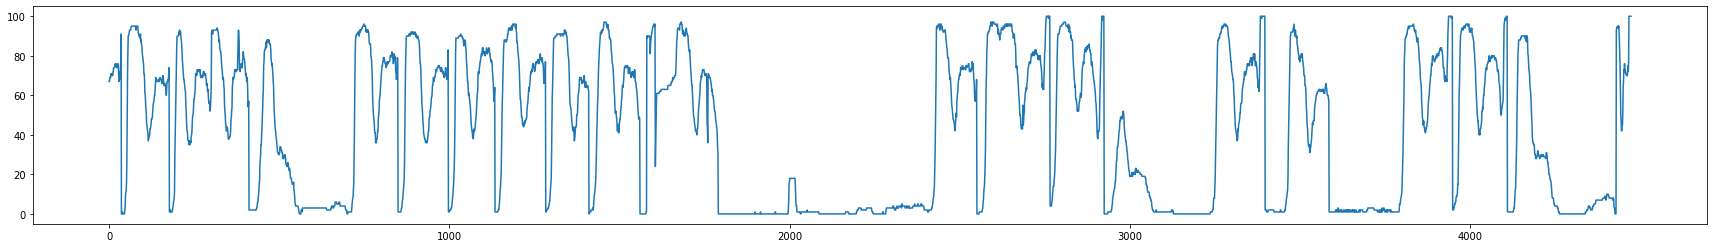

In [ ]:
plt.figure(figsize=(30, 4))
plt.plot(PUCPR['occupied'])

In [ ]:
X = PUCPR[['weather', 'weekday', 'year', 'month', 'day', 'hour', 'minutes', 'weekday']]
y = PUCPR[['occupied']]

In [ ]:
y

,occupied
0,67
1,67
2,69
3,69
4,69
...,...
4468,100
4469,100
4470,100
4471,100


In [ ]:
X

,weather,weekday,year,month,day,hour,minutes,weekday
0,2,1,2012,09,11,15,16,1
1,2,1,2012,09,11,15,27,1
2,2,1,2012,09,11,15,29,1
3,2,1,2012,09,11,15,31,1
4,2,1,2012,09,11,15,36,1
...,...,...,...,...,...,...,...,...
4468,2,1,2012,11,20,18,39,1
4469,2,1,2012,11,20,18,54,1
4470,2,1,2012,11,20,19,09,1
4471,2,1,2012,11,20,19,24,1


In [ ]:
X_ss, y_mm, mm = scaler(X, y)
X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors = train_test_split(X_ss, y_mm)

In [ ]:
batch_size = 16
train_data = TensorDataset(X_train_tensors_final, y_train_tensors)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
gru_model = train(train_loader, learning_rate, model_type="GRU")
Lstm_model = train(train_loader, learning_rate, model_type="LSTM")

Starting Training of GRU model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1......Step: 200/223....... Average Loss for Epoch: 0.10383862760849297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 2......Step: 200/223....... Average Loss for Epoch: 0.07573337349109352
Epoch 3......Step: 200/223....... Average Loss for Epoch: 0.06365612395573407
Epoch 4......Step: 200/223....... Average Loss for Epoch: 0.050222463053651155
Epoch 5......Step: 200/223....... Average Loss for Epoch: 0.0403850568132475
Epoch 6......Step: 200/223....... Average Loss for Epoch: 0.03184575444087386
Epoch 7......Step: 200/223....... Average Loss for Epoch: 0.028064848051872104
Epoch 8......Step: 200/223....... Average Loss for Epoch: 0.02301857300568372
Epoch 9......Step: 200/223....... Average Loss for Epoch: 0.021121632950380446
Epoch 10......Step: 200/223....... Average Loss for Epoch: 0.020983492333907634
Epoch 11......Step: 200/223....... Average Loss for Epoch: 0.01823223308485467
Epoch 12......Step: 200/223....... Average Loss for Epoch: 0.016303837405284866
Epoch 13......Step: 200/223....... Average Loss for Epoch: 0.01589289667434059
Epoch 14......Step: 200/223....... Average Loss for Epoc

In [ ]:
PATH = dr_path + 'models/GRUPUCPR.pth'
torch.save(gru_model.state_dict(), PATH)
PATH = dr_path + 'models/LSTMPUCPR.pth'
torch.save(Lstm_model.state_dict(), PATH)

In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, X_test_tensors_final, y_test_tensors, mm)

Evaluation Time: 0.009298999999828084
sMAPE: 91.92490577697754%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(Lstm_model, X_test_tensors_final, y_test_tensors, mm)

Evaluation Time: 0.013328000000001339
sMAPE: 26.836439967155457%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


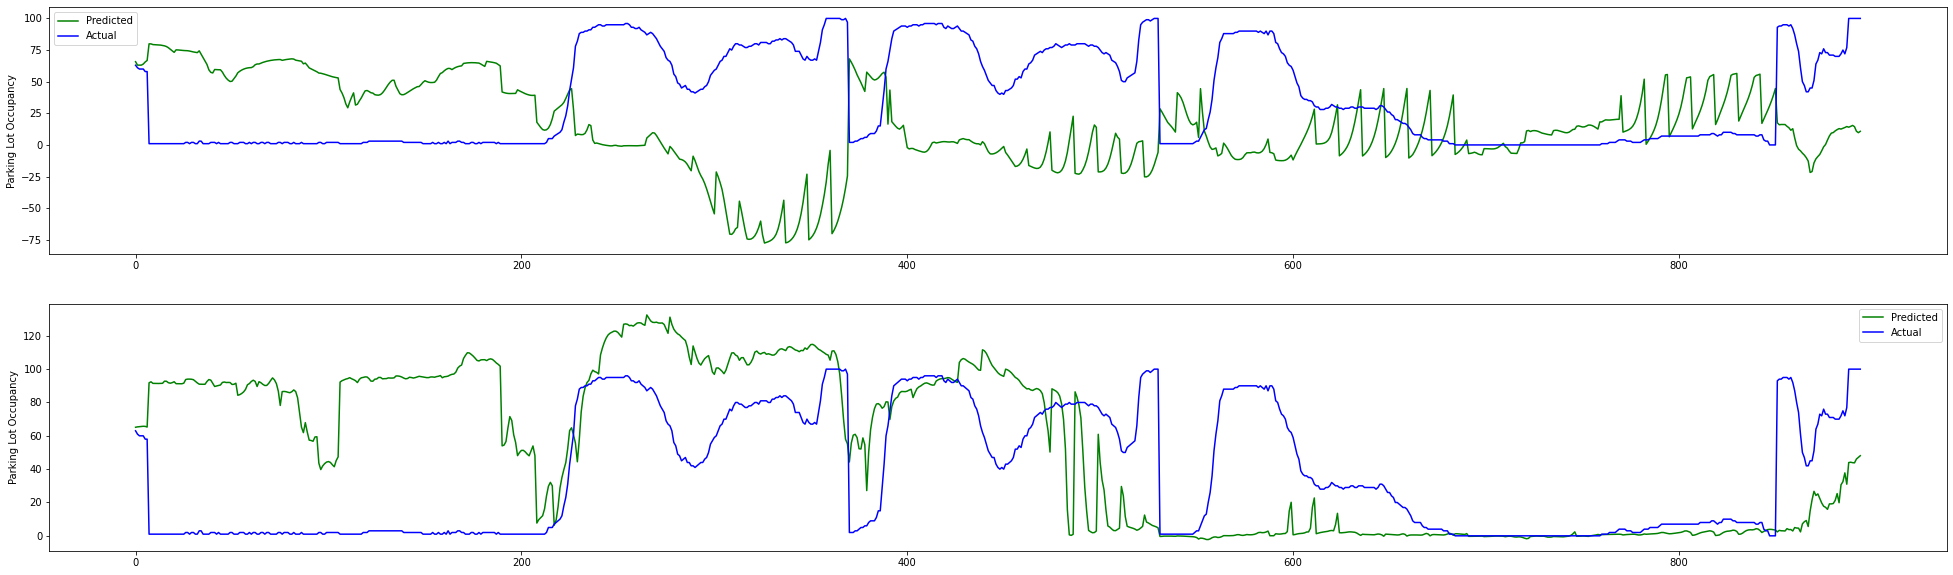

In [ ]:
plt.figure(figsize=(34,10))
plt.subplot(2, 1, 1)
plt.plot(gru_outputs[0], color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Parking Lot Occupancy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(lstm_outputs[0], color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Parking Lot Occupancy')
plt.legend()
plt.show()